# Data Exploration Notebook

In [47]:
import os

%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import torch
import numpy as np
from scipy import interpolate

In [48]:
lms_files = [os.path.join("sequences", file) for file in os.listdir("sequences") if ".ipynb" not in file]
lms_files.sort()
mp3_files = [os.path.join("audio", file) for file in os.listdir("audio") if ".ipynb" not in file]
mp3_files.sort()

In [49]:
file_idx = 4

In [50]:
mp3_files[file_idx]

'audio/DMHO - Jingle_Bells.mp3'

## TODO

* Use only Unit 1 as output (simplify)
* Create converter for compressed files (gain access to many more files) - [instructions here](https://github.com/Cryptkeeper/lightorama-protocol)
    * Include Halloween songs as well to maximimize dataset (underlying principles should be the same)
* Conduct more rigorous correlation examination and exclude features that appear to have little correlation with sequence
    * In my brief initial examination, there seemed to be roughly half of the extracted features that had essentially zero correlation with any of the units
* Include some amount of previous sequence information in training input 
    * I.e. *n* previous centiseconds output + *n* previous centiseconds audio + this centisecond audio
    * Domain knowledge would imply that the previous sequence choices are very important for current sequence choice

## Light Sequences<effect type="intensity" startCentisecond="17436" endCentisecond="17686" startIntensity="100" endIntensity="0"/>

### Process file to convert to sequences
* File is stored as XML-like set of containers with tags describing what containers hold what. 
* Each "channel" refers to a different unit and circuit. Within these is the information that describes the light show. As we go through the file, we first collect each of these and store them each in a list. 
* At the end of the file is another container with 10 centisecond increments from start to finish of the song. We collect this ato provide a basis for the time series

In [51]:
file = open(lms_files[file_idx])
lines = file.readlines()

sequences = []

for idx in range(len(lines)):
    line = lines[idx].strip()
    if "<channel name=" in line or line == "<timingGrids>":
        sequence = []
        while line != "</channel>" and line != "</timingGrids>":
            line = lines[idx].strip()
            sequence.append(line)
            idx+=1
        sequences.append(sequence)
timing_grid = sequences[-1][2:-2]
trim_sequences = sequences[:-1]

### Create dataframe to hold timing grid

In [52]:
timing_df = pd.DataFrame(columns=["time"])
for line in timing_grid:
    timing_df.loc[len(timing_df)] = [line.split('"')[1]]
display(timing_df)

,time
0,0
1,1
2,2
3,12
4,22
...,...
2038,20271
2039,20281
2040,20286
2041,20291


* Unit 1 - Melody
* Unit 2 - Harmony/Accents
* Unit 3 - Melody/Beat

### Collect Sequence and Channel Information
* Each outer channel container gives information on the channel including unit, circuit, name, color, and length in centiseconds
* Within this outer container, numerous entries provide light information for a subset of time. This information includes effect type {intensity, twinkle}, start time in centiseconds, end time in centiseconds, starting intensity in percent, ending intensity in percent. 
* Information about each channel is stored in **channel_df**
* Information about each sequence entry is stored in **sequence_df**
* For each entry in sequence_df, the unit and circuit is included as well to identify. This can be cross-referenced with channel_df if additional information is needed

### Unit Descriptions

* Unit 1 - Melody
* Unit 2 - Harmony/Accents
* Unit 3 - Melody/Beat

In [53]:
sequence_df = pd.DataFrame(columns=["unit", "circuit", "type", "start", "end", "start_intensity", "end_intensity"])
channel_df = pd.DataFrame(columns=["unit", "circuit", "name", "color", "length"])
for sequence in trim_sequences:
    for idx, line in enumerate(sequence):
        line_arr = line.split('"')
        if idx == 0:
            channel_name = line_arr[1]
            color = int(line_arr[3])
            length = int(line_arr[5])
            unit = int(line_arr[9])
            circuit = int(line_arr[11])
            channel_df.loc[len(channel_df)] = [unit, circuit, channel_name, color, length]
        elif idx == (len(sequence) - 1):
            pass
        else:
            effect_type = 0 if line_arr[1] == "intensity" else 1
            if len(line_arr) > 9:
                sequence_df.loc[len(sequence_df)] = [unit, circuit, effect_type, int(line_arr[3]), int(line_arr[5]), int(line_arr[7]), int(line_arr[9])]
            else:
                sequence_df.loc[len(sequence_df)] = [unit, circuit, effect_type, int(line_arr[3]), int(line_arr[5]), int(line_arr[7]), int(line_arr[7])]
display(channel_df)
display(sequence_df)

,unit,circuit,name,color,length
0,1,8,Unit 01.8,4227072,20300
1,1,9,Unit 01.9,255,20300
2,1,10,Unit 01.10,32768,20300
3,1,11,Unit 01.11,255,20300
4,1,12,Unit 01.12,4227072,20300
5,1,13,Unit 01.13,255,20300
6,1,14,Unit 01.14,32768,20300
7,1,15,Unit 01.15,255,20300
8,1,16,Unit 01.16,4227072,20300
9,2,1,Unit 02.1,12615744,20300


,unit,circuit,type,start,end,start_intensity,end_intensity
0,1,8,0,102,352,0,86
1,1,8,0,512,762,0,86
2,1,8,0,802,1222,0,100
3,1,8,0,1222,1242,100,100
4,1,8,0,1302,1382,100,100
...,...,...,...,...,...,...,...
11509,1,7,0,19641,19671,100,0
11510,1,7,0,19671,19701,100,0
11511,1,7,0,19701,19801,100,0
11512,1,7,1,19801,20211,100,100


### Visualize Channel Information
* This interactive plot displays the time series intensity information for each channel. The goal will be to reproduce this data with a neural network, so it is important to understand what this data should look like

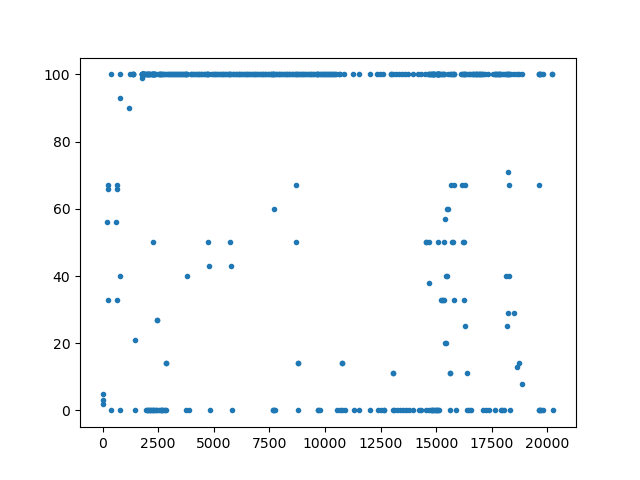

In [54]:
def update_plot(event):
    ax.cla()
    sub_df = sequence_df[(sequence_df["unit"] == channel_df.iloc[dropdown_w.value, 0]) & (sequence_df["circuit"] == channel_df.iloc[dropdown_w.value, 1])]
    for index, row in sub_df.iterrows():
        with out_w:
            ax.plot((int(row["start"]), int(row["end"])), (int(row["start_intensity"]), int(row["end_intensity"])), 
                     color="C0", linestyle="", marker=".")
    
out_w = widgets.Output()

with out_w:
    fig, ax = plt.subplots()
    
options = []
for index, row in channel_df.iterrows():
    options.append((row['name'], index))
options.sort()

dropdown_w = widgets.Dropdown(options=options, description='Channel:')

update_plot("origin")

box = widgets.HBox([out_w, dropdown_w])

dropdown_w.observe(update_plot, names="value")
                    
display(box)

In [55]:
dense_seqs = {}

for unit in np.unique(sequence_df["unit"]):
    dense_seqs[unit] = {}
    
    for circuit in np.unique(sequence_df[sequence_df["unit"] == unit]["circuit"]):
        seq = np.zeros(int(channel_df.iloc[0]["length"]))
        
        sparse_seqs = sequence_df[(sequence_df["unit"] == unit) & (sequence_df["circuit"] == circuit)]
        for idx, row in sparse_seqs.iterrows():
            f = interpolate.interp1d([row["start"], row["end"]], [row["start_intensity"], row["end_intensity"]])
            xnew = np.arange(row["start"], row["end"]+1, 1)
            ynew = f(xnew)
            seq[row["start"]-1:row["end"]] = ynew
            
        dense_seqs[unit][circuit] = seq

## Music Files

### Raw Analysis

In [ ]:
from glob import glob
from pydub import AudioSegment
from pydub.utils import mediainfo

In [277]:
audio_file = AudioSegment.from_file(mp3_files[file_idx])

frame_rate = audio_file.frame_rate
sample_width = audio_file.sample_width
channels = audio_file.channels

data = audio_file._data

In [278]:
pcm16_signed_integers = []

for sample_index in range(len(data)//2):
    sample = int.from_bytes(data[sample_index*2:sample_index*2+2], 'little', signed=True)
    pcm16_signed_integers.append(sample)

In [279]:
sequence_length = int(channel_df.iloc[0]["length"]) / 100 / 60
diff = ((len(pcm16_signed_integers) / frame_rate / channels / 60) - sequence_length) * frame_rate * channels * 60

In [280]:
trimmed_signal = pcm16_signed_integers[:-int(diff)]

/var/folders/tx/_hcllz396pb86lnbb7dygsf80000gn/T/ipykernel_10785/2054443137.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


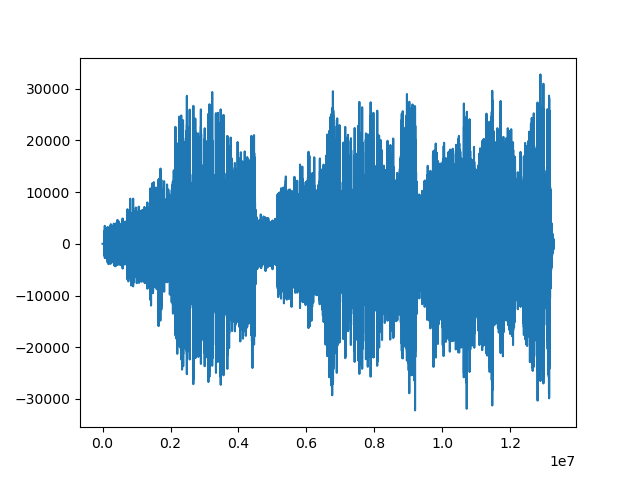

In [281]:
fig, ax = plt.subplots()
ax.plot(trimmed_signal)

### Feature Extraction

In [56]:
from pyAudioAnalysis import ShortTermFeatures as aF
from pyAudioAnalysis import audioBasicIO as aIO 

In [57]:
fs, s = aIO.read_audio_file(mp3_files[file_idx])
s = aIO.stereo_to_mono(s)

In [58]:
win, step = 0.01, 0.01
[f, fn] = aF.feature_extraction(s, fs, int(fs * win), 
                                int(fs * step))
f = f[:, :int(channel_df.iloc[0]["length"])]
print(f'{f.shape[1]} frames, {f.shape[0]} short-term features')

20300 frames, 68 short-term features


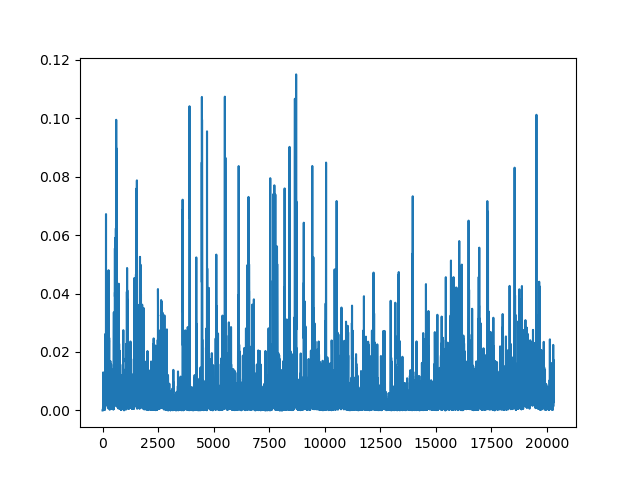

In [73]:
def update_plot(event):
    ax.cla()
    with out_w:
        ax.plot(f[dropdown_w.value])
    
out_w = widgets.Output()

with out_w:
    fig, ax = plt.subplots()
    
options = []
for index, feature in enumerate(fn):
    options.append((feature, index))
options.sort()

dropdown_w = widgets.Dropdown(options=options, description='Feature:')

update_plot("origin")

box = widgets.HBox([out_w, dropdown_w])

dropdown_w.observe(update_plot, names="value")
                    
display(box)

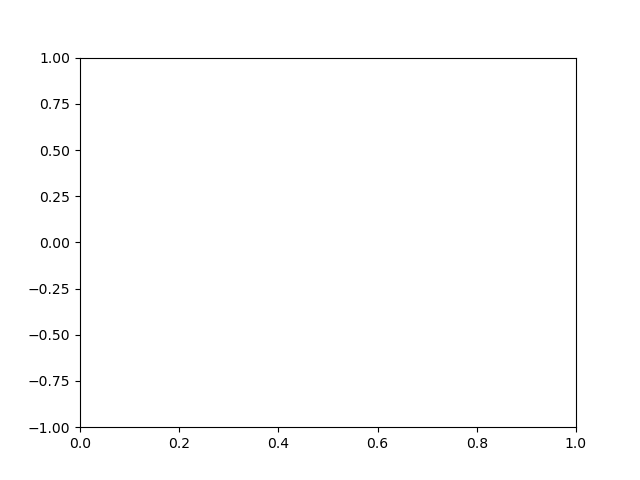

In [117]:
def update_plot(event):
    ax.cla()
    ax.set(ylim=[-1, 1])
    with out_w:
        plot_idx = 0
        for unit in range(3):
            for circuit in range(16):
                ax.scatter(plot_idx, np.corrcoef(dense_seqs[unit+1][circuit+1], f[dropdown_w.value])[0][1])
                plot_idx += 1
    
out_w = widgets.Output()

with out_w:
    fig, ax = plt.subplots()
    ax.set(ylim=[-1, 1])
    
options = []
for index, feature in enumerate(fn):
    options.append((feature, index))
options.sort()

dropdown_w = widgets.Dropdown(options=options, description='Feature:')

update_plot("origin")

box = widgets.HBox([out_w, dropdown_w])

dropdown_w.observe(update_plot, names="value")
                    
display(box)

In [75]:
import vamp
import librosa

In [92]:
# audio, sr = librosa.load(mp3_files[file_idx], sr=44100, mono=True)

In [95]:
fs, s = aIO.read_audio_file(mp3_files[file_idx])
s = aIO.stereo_to_mono(s)

In [93]:
audio

array([], dtype=float32)

In [94]:
sr

44100

In [96]:
data = vamp.collect(s, fs, "mtg-melodia:melodia")

In [97]:
data

{'vector': ( 0.002902494,
  array([-440., -440., -440., ...,    0.,    0.,    0.], dtype=float32))}

In [99]:
timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)

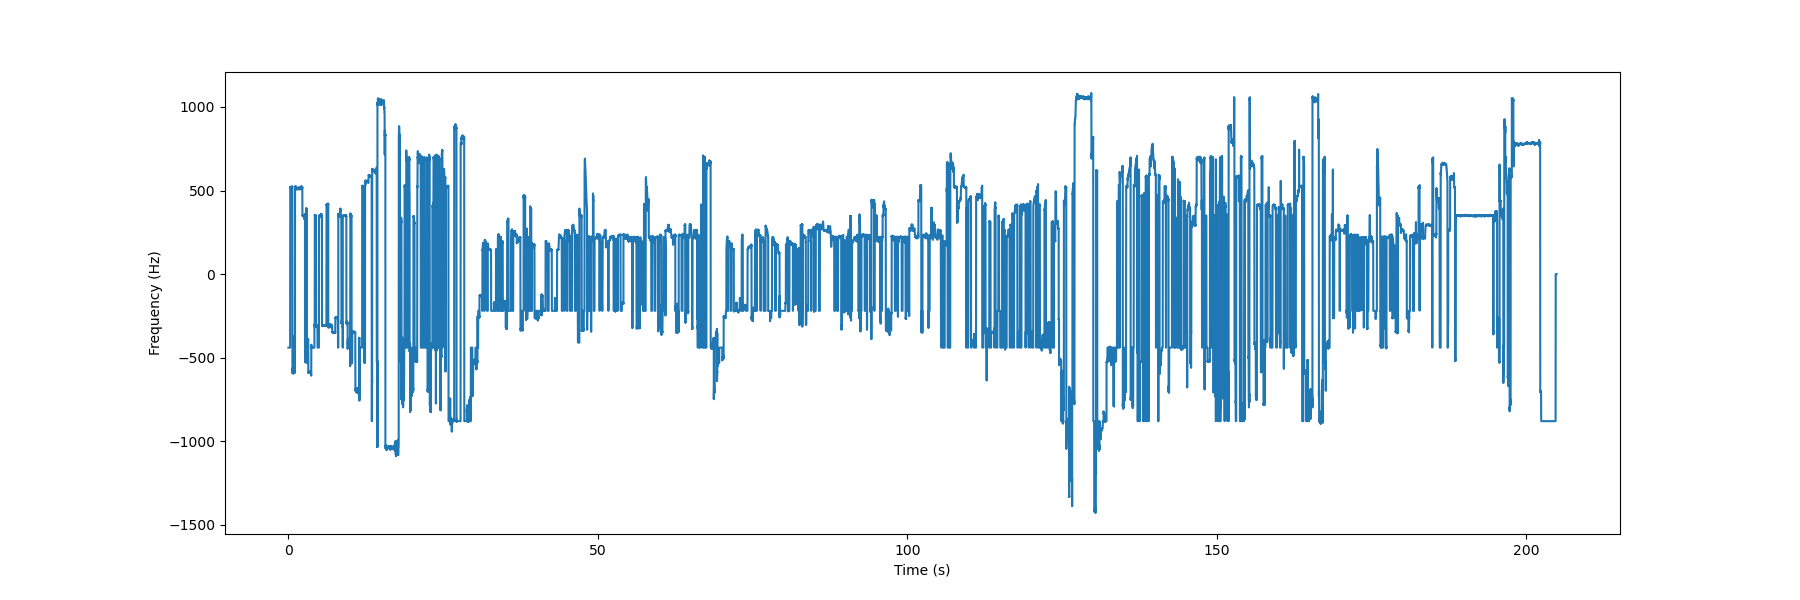

In [100]:
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [101]:
len(melody)

70587

In [103]:
import scipy

In [105]:
f = scipy.interpolate.interp1d(timestamps, melody)

In [106]:
x_new = np.arange(timestamps[0], timestamps[-1], 0.01)
y_new = f(x_new)

In [123]:
len(x_new)

20488

In [122]:
len(y_new)

20300

In [124]:
len(dense_seqs[1][1])

20300

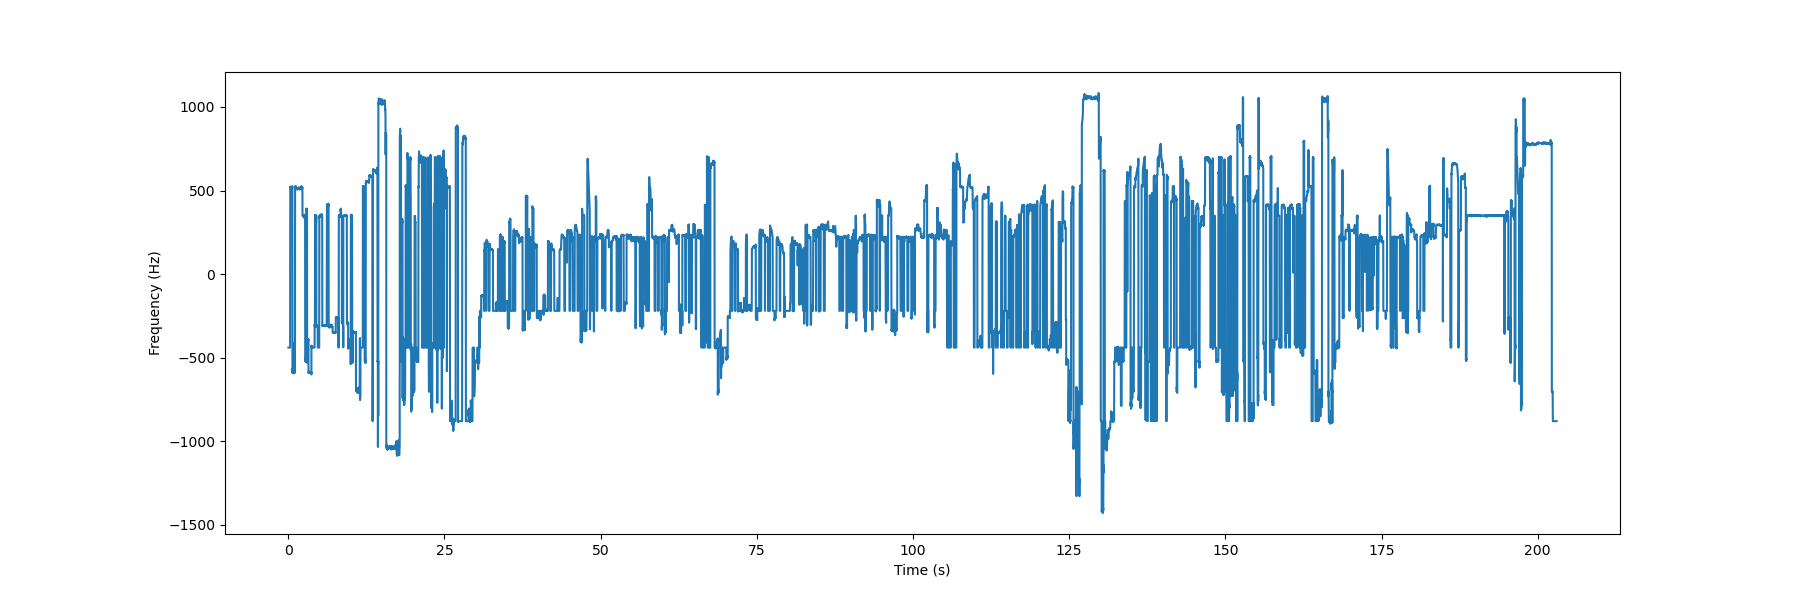

In [126]:
plt.figure(figsize=(18,6))
plt.plot(x_new[:20300], y_new)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()
plt.plot(x_new[:20300], dense_seqs[1][1])

In [120]:
y_new = y_new[:20300]

In [113]:
len(y_new)

20300

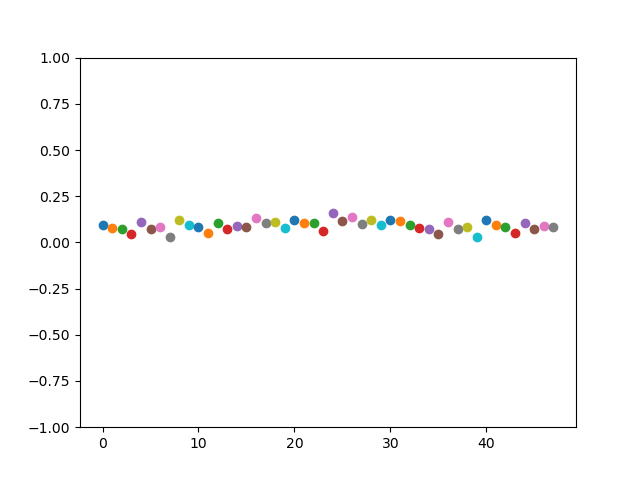

In [116]:
fig, ax = plt.subplots()
ax.set(ylim=[-1, 1])
plot_idx = 0
for unit in range(3):
    for circuit in range(16):
        ax.scatter(plot_idx, np.corrcoef(dense_seqs[unit+1][circuit+1], y_new)[0][1])
        plot_idx += 1